In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

import warnings 

warnings.filterwarnings('ignore')

%matplotlib inline


/root/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [24]:
def mean_absolut_percentage_error(ytrue, ypred):
    return np.mean(np.abs(ytrue-ypred)/ytrue)*100


In [25]:
data  = pd.read_csv('data/stock_prices_sample.csv', index_col = ['DATE'], parse_dates = ['DATE'])
data.head(1000)

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-27,GF,BBG000C3C6S2,EOD,daily,18.63,18.6300,18.51,18.61,28400.0,11.717560,11.717560,11.642085,11.704981,28400.0,NaN,0.0,1.0
2014-06-26,GF,BBG000C3C6S2,EOD,daily,18.52,18.5901,18.42,18.53,60000.0,11.648374,11.692464,11.585478,11.654664,60000.0,NaN,0.0,1.0
2014-06-25,GF,BBG000C3C6S2,EOD,daily,18.66,18.7200,18.59,18.60,171700.0,11.736429,11.774167,11.692402,11.698691,171700.0,NaN,0.0,1.0


In [26]:
#cleaning the data 
#we only want to use GF and EOD

data  = data[data.TICKER != 'GEF']
data = data[data.TYPE != 'Itraday']
drop_cols = ['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_VOLUME', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH', 'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']

data.drop(drop_cols, axis=1, inplace=True)

data.head(10000)

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-05,GF,18.86,18.9100,18.8700,18.87
2018-06-04,GF,18.86,18.8900,18.7900,18.81
2018-06-01,GF,18.58,18.7600,18.5800,18.74
2018-05-31,GF,18.52,18.5200,18.3012,18.49
2018-05-30,GF,18.47,18.6780,18.4700,18.65
...,...,...,...,...,...
2014-06-27,GF,18.63,18.6300,18.5100,18.61
2014-06-26,GF,18.52,18.5901,18.4200,18.53
2014-06-25,GF,18.66,18.7200,18.5900,18.60


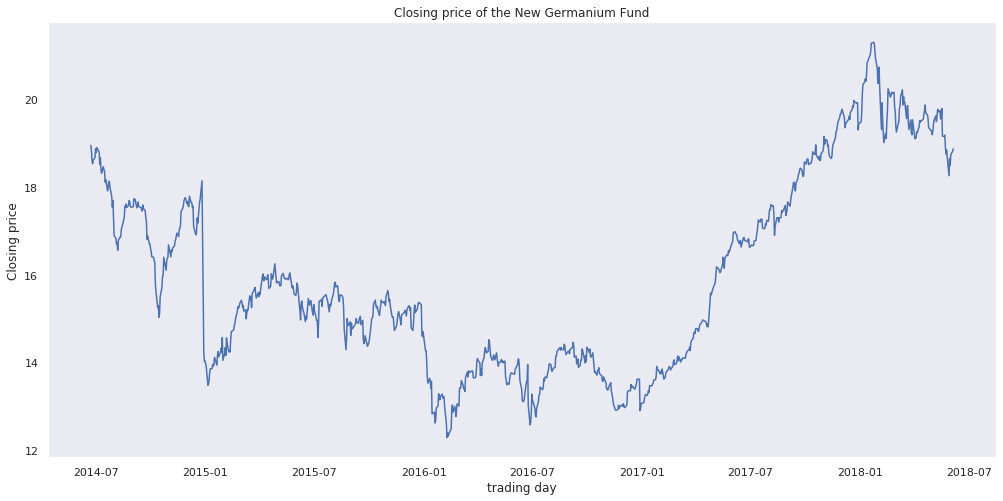

In [27]:
#analysis

plt.figure(figsize = (17, 8))
plt.plot(data.CLOSE)
plt.title('Closing price of the New Germanium Fund')
plt.xlabel('trading day')
plt.ylabel('Closing price')
plt.grid(False)
plt.show()

In [28]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

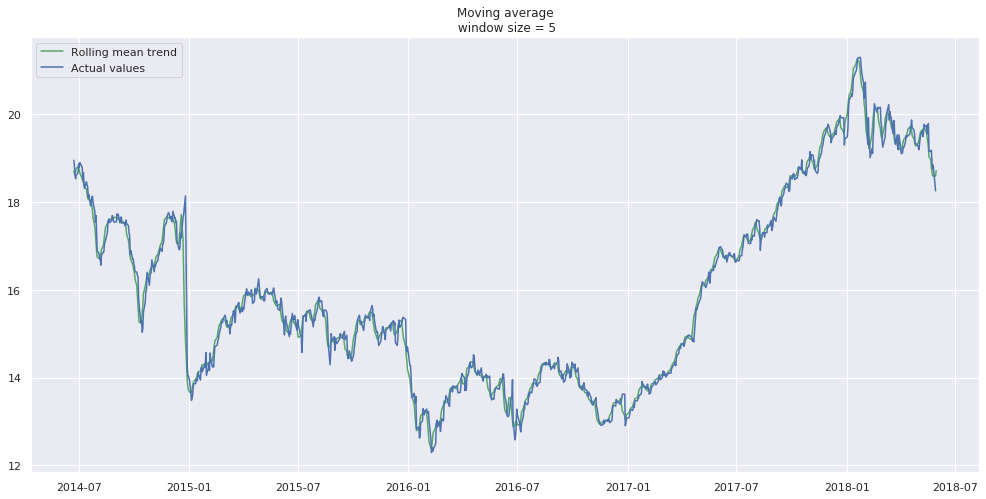

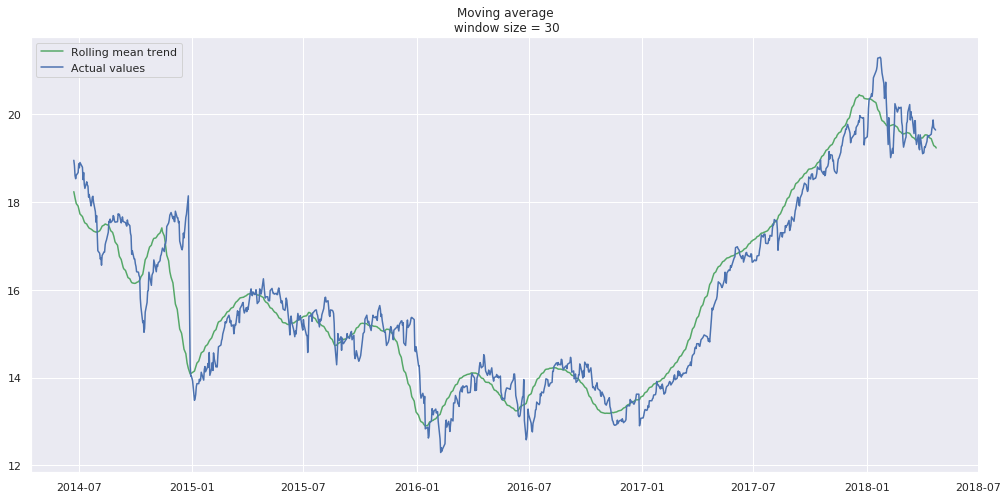

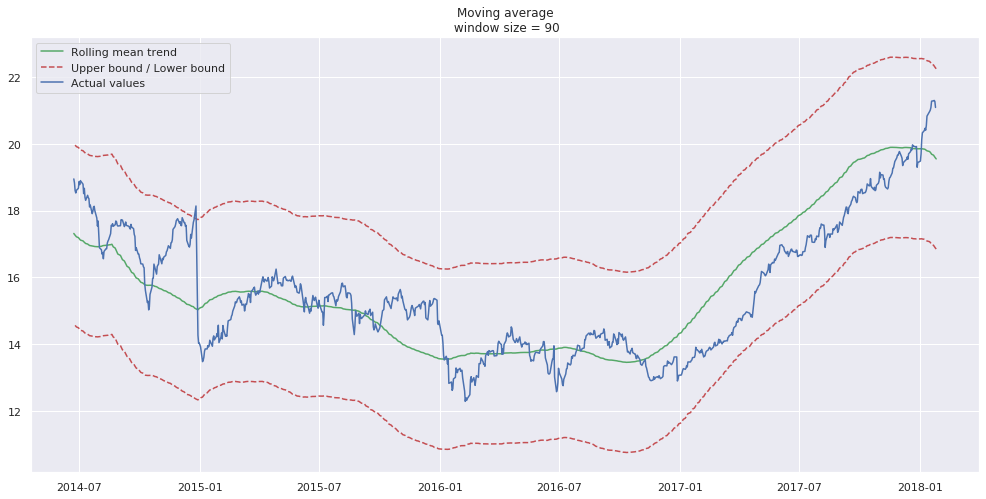

In [29]:
#Smooth by the previous 5 days (by week)
plot_moving_average(data.CLOSE, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.CLOSE, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.CLOSE, 90, plot_intervals=True)
